Agora vamos realizar testes usando Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('train_normalized.csv')
df_test = pd.read_csv('test_normalized.csv')

In [4]:
X_train = df_train.drop('satisfaction', axis=1)
y_train = df_train['satisfaction']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_test = df_test.drop('satisfaction', axis=1)  
y_test = df_test['satisfaction']

In [6]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

best_clf = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [8]:
y_test_pred = best_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_cm)
print('Test Classification Report:')
print(test_report)

Test Accuracy: 0.9600785340314136
Test Confusion Matrix:
[[14185   388]
 [  649 10754]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14573
           1       0.97      0.94      0.95     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



In [9]:
from sklearn.model_selection import cross_val_score

# Realizar a validação cruzada com 5 folds
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=5, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')


Cross-validation scores: [0.96529665 0.96546649 0.9618433  0.96263375 0.97503255]
Mean CV score: 0.9660545478522202


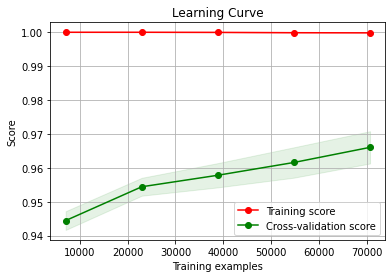

In [10]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Gerar curva de aprendizado
train_sizes, train_scores, val_scores = learning_curve(best_clf, X_train, y_train, cv=5, n_jobs=-1)

# Calcular médias e desvios padrões
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plotar curva de aprendizado
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

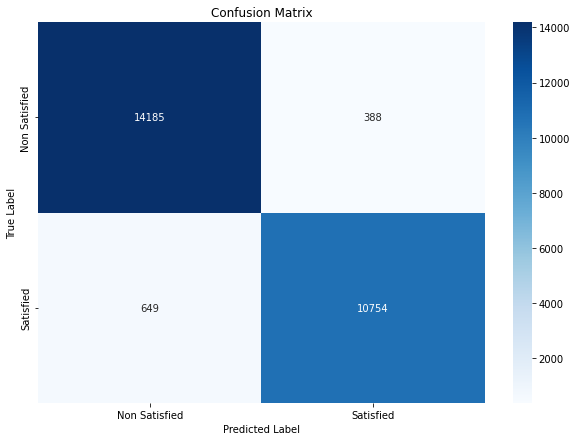

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Satisfied', 'Satisfied'], yticklabels=['Non Satisfied', 'Satisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

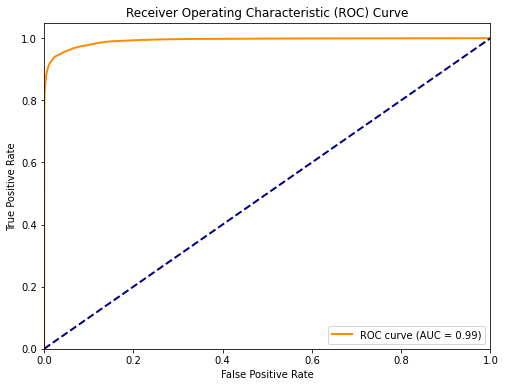

In [14]:
from sklearn.metrics import roc_curve, auc


y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

# Visualizar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

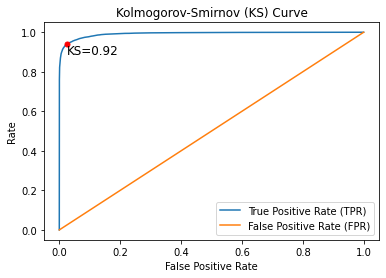

KS Statistic: 0.92


In [17]:
from scipy.stats import ks_2samp

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Calculando a estatística KS
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)

plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")